In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets, svm, tree
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [2]:
# http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29
# http://archive.ics.uci.edu/ml/datasets/Mammographic+Mass
# http://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data

In [3]:
X = dict()
y = dict()

# Load WDBC dataset
data = np.loadtxt("wdbc.data", delimiter=',')
X[0] = data[:, 2:]
y[0] = data[:,  1]

# Load Mammogram Mass dataset
data = np.loadtxt("mmass.data", delimiter=',')
X[1] = data[:, :5]
y[1] = data[:,  5]

# Load Thoraric Surgery dataset
data = np.loadtxt("ts.data", delimiter=',')
X[2] = data[:, :27]
y[2] = data[:,  27]

In [4]:
def ROC(X, y, clf, split):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=0)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    return fpr, tpr

In [5]:
clf = dict()
# Decision tree
clf[0] = tree.DecisionTreeClassifier()
# Random Forest
clf[1] = RandomForestClassifier(n_estimators=100)
# Adaboost
clf[2] = AdaBoostClassifier(n_estimators=100)
# Naive Bayes
clf[3] = GaussianNB()
# SVM
clf[4] = svm.SVC(probability=True)
# Logistic Regression
clf[5] = linear_model.LogisticRegression(C=1e5)

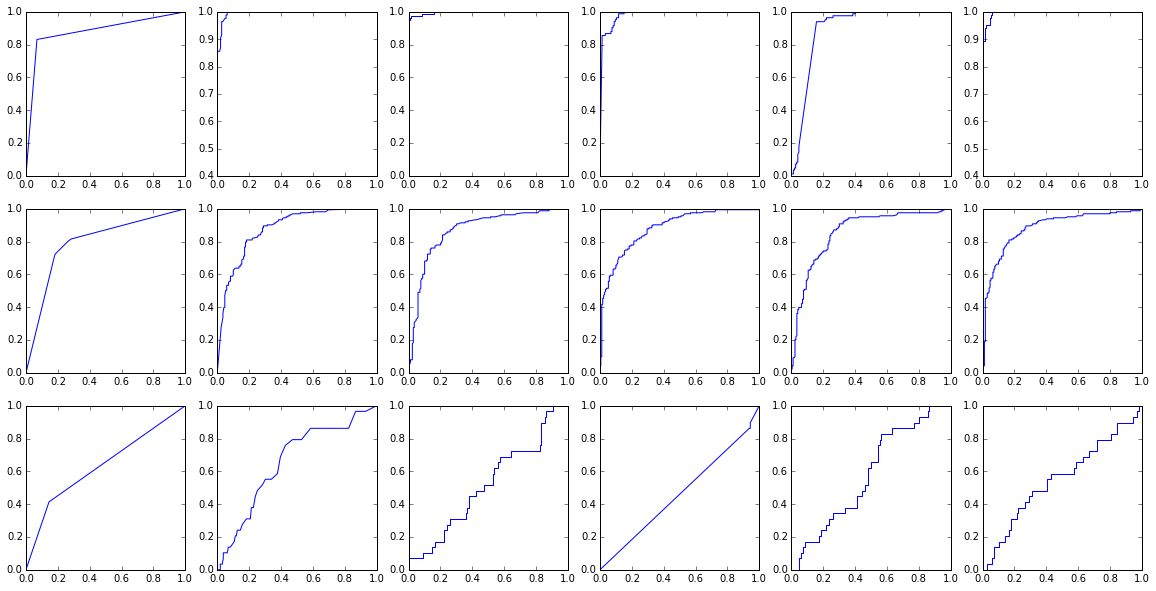

In [23]:
split = 0.4
aucs = np.zeros((3, 6))


f = plt.figure(figsize=(20,10))
for i in xrange(0, 3):
    for c in xrange(0, 6):
        fpr, tpr = ROC(X[i], y[i], clf[c], split)
        plt.subplot(3, 6, 6*i+c+1)
        plt.plot(fpr, tpr)
        aucs[i, c] = auc(fpr, tpr)
        

In [24]:
print(aucs)

[[ 0.88117989  0.99551309  0.99684254  0.9806398   0.897715    0.99651018]
 [ 0.79458743  0.87526772  0.86813446  0.87944241  0.85591897  0.88256434]
 [ 0.63456951  0.6584255   0.52288007  0.46302321  0.5814357   0.55953155]]
